# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [6]:
!pip install labelme tensorflow  opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:
for i in range(5):  # Check for the first 5 camera indices
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Camera index {i} is working")
        cap.release()
    else:
        print(f"Camera index {i} is not available")

Camera index 0 is working
Camera index 1 is not available
Camera index 2 is not available
Camera index 3 is not available
Camera index 4 is not available


In [13]:

cap = cv2.VideoCapture(0)  # Make sure to use the correct camera index

if not cap.isOpened():
    print("Error: Could not open video stream or file")
else:
    for imgnum in range(number_images):
        print('Collecting image {}'.format(imgnum))
        ret, frame = cap.read()

        if not ret:
            print("Error: Could not read frame from camera")
            break
        
        imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)  # Save the image
        time.sleep(0.5)  # Adjust this delay based on your requirement

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


### 1.3 Annotate Images with LabelMe

In [15]:
!labelme

2024-09-27 10:28:31,325 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\DELL\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [16]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.3 Load Image into TF Data Pipeline

In [17]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [18]:
images.as_numpy_iterator().next()

b'data\\images\\d3f1177a-7c8b-11ef-9e3f-ca39ccf5f82e.jpg'

In [19]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [20]:
images = images.map(load_image)

In [21]:
images.as_numpy_iterator().next()

array([[[249, 255, 253],
        [249, 255, 253],
        [249, 255, 253],
        ...,
        [171, 184, 190],
        [170, 185, 190],
        [167, 182, 187]],

       [[249, 255, 253],
        [249, 255, 253],
        [249, 255, 253],
        ...,
        [168, 181, 187],
        [170, 183, 189],
        [168, 181, 187]],

       [[249, 255, 253],
        [249, 255, 253],
        [250, 254, 253],
        ...,
        [169, 178, 185],
        [172, 181, 188],
        [172, 183, 189]],

       ...,

       [[118, 119, 114],
        [116, 117, 112],
        [116, 117, 112],
        ...,
        [ 42,  46,  47],
        [ 42,  47,  50],
        [ 44,  49,  52]],

       [[116, 118, 113],
        [115, 117, 112],
        [114, 116, 111],
        ...,
        [ 41,  45,  48],
        [ 43,  48,  52],
        [ 44,  49,  53]],

       [[115, 120, 114],
        [114, 119, 113],
        [115, 117, 112],
        ...,
        [ 42,  46,  49],
        [ 43,  48,  54],
        [ 44,  49,  55]]

In [40]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [7]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [28]:
plot_images = image_generator.next()

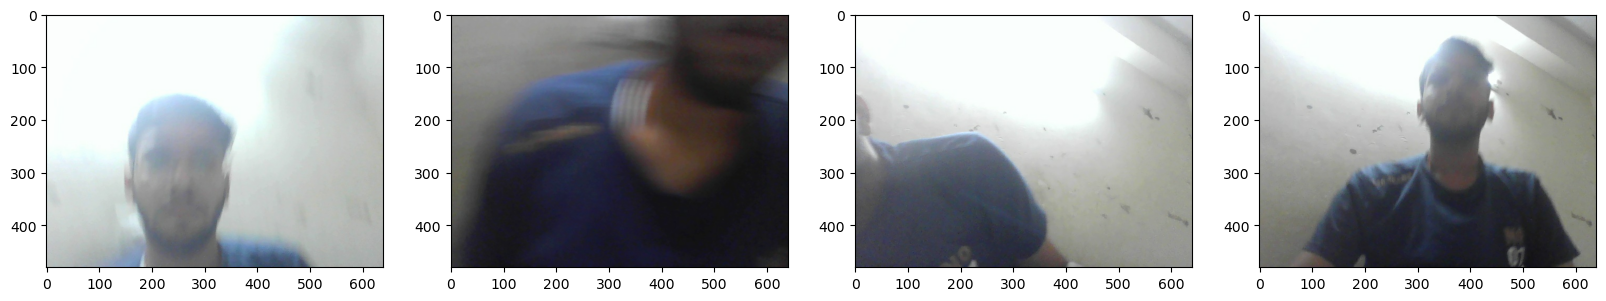

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [33]:
30*.7 # 20 to train

21.0

In [34]:
30*.15 # 5 and 5 to test and val

4.5

### 3.2 Move the Matching Labels

In [35]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [126]:
import albumentations as alb

In [127]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [128]:
img = cv2.imread(os.path.join('data','train', 'images','d1f781b3-7c8b-11ef-a405-ca39ccf5f82e.jpg'))

In [129]:
img.shape


(480, 640, 3)

In [130]:
with open(os.path.join('data', 'train', 'labels', 'd1f781b3-7c8b-11ef-a405-ca39ccf5f82e.json'), 'r') as f:
    label = json.load(f)

In [131]:
label['shapes'][0]['points']

[[307.5, 173.88888888888889], [581.9444444444443, 464.44444444444446]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [132]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [133]:
coords

[307.5, 173.88888888888889, 581.9444444444443, 464.44444444444446]

In [134]:
coords = list(np.divide(coords, [640,480,640,480]))

In [135]:
coords

[0.48046875, 0.3622685185185185, 0.9092881944444443, 0.9675925925925927]

### 4.4 Apply Augmentations and View Results

In [136]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [137]:
augmented['bboxes'][0][2:]

[0.9620987277560764, 0.6135802586873372]

In [138]:
augmented['bboxes']

[[0.3522222222222222, 0.0, 0.9620987277560764, 0.6135802586873372]]

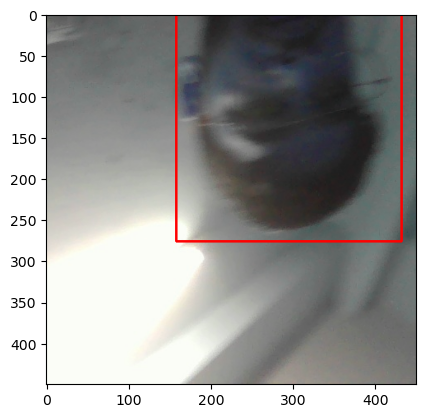

In [139]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [140]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
y_max is less than or equal to y_min for bbox [0.2000868  0.6388889  0.65581596 0.00462963 0.        ].
y_max is less than or equal to y_min for bbox [0.2860243  0.74189812 0.79817706 0.01041667 0.        ].
y_max is less than or equal to y_min for bbox [0.15668403 0.55208331 0.72439235 0.01041667 0.        ].
x_max is less than or equal to x_min for bbox [0.24262153 0.01041667 0.00477431 0.85416669 0.        ].
y_max is less than or equal to y_min for bbox [0.76605904 0.86689812 0.99175346 0.00115741 0.        ].
y_max is less than or equal to y_min for bbox [0.56987846 0.6423611  0.99348956 0.01388889 0.        ].
y_max is less than or equal to y_min for bbox [0.53776044 0.77430558 0.99348956 0.00925926 0.        ].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [141]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [142]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [143]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [144]:
train_images.as_numpy_iterator().next()

array([[[0.04405637, 0.04405637, 0.0471201 ],
        [0.04803922, 0.04803922, 0.04803922],
        [0.04362745, 0.04362745, 0.04362745],
        ...,
        [0.21617647, 0.21617647, 0.21617647],
        [0.21893382, 0.22677696, 0.215625  ],
        [0.19148284, 0.20422794, 0.20226716]],

       [[0.04460784, 0.04460784, 0.0442402 ],
        [0.04705882, 0.04705882, 0.04607843],
        [0.05055147, 0.05055147, 0.04957108],
        ...,
        [0.21703431, 0.21703431, 0.20919117],
        [0.22310048, 0.23082107, 0.21911764],
        [0.1870098 , 0.19240196, 0.19644608]],

       [[0.04883578, 0.04883578, 0.04099265],
        [0.05147059, 0.05147059, 0.04362745],
        [0.05055147, 0.05055147, 0.04270833],
        ...,
        [0.22058824, 0.22058824, 0.2127451 ],
        [0.22046569, 0.22732843, 0.22291666],
        [0.18939951, 0.19332108, 0.20606618]],

       ...,

       [[0.48872548, 0.49656862, 0.44381127],
        [0.5036152 , 0.51531863, 0.4819853 ],
        [0.4995098 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [145]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [150]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [151]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [152]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [153]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.    , 0.2129, 0.6147, 1.    ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [17]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

NameError: name 'train_images' is not defined

### 7.2 Create Final Datasets (Images/Labels)

In [159]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2000)
train = train.batch(8)
train = train.prefetch(4)

In [160]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(500)
test = test.batch(8)
test = test.prefetch(4)

In [161]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(8)
val = val.prefetch(4)

In [162]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.2155 , 0.02815, 0.7983 , 0.875  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.02592, 0.4424 , 0.873  ],
        [0.4878 , 0.1482 , 0.7925 , 0.584  ],
        [0.07916, 0.     , 0.7236 , 0.787  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.398  , 0.4858 , 0.945  ]], dtype=float16))

### 7.3 View Images and Annotations

In [173]:
data_samples = train.as_numpy_iterator()

In [174]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


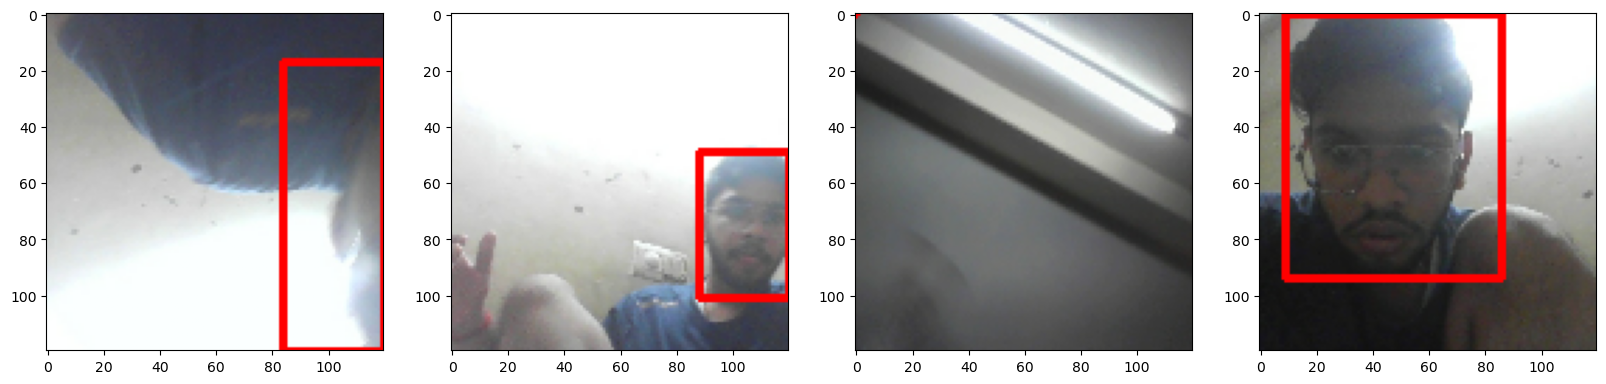

In [175]:

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4): 
    sample_image = np.copy(res[0][idx])  # Create a writable copy of the image
    sample_coords = res[1][1][idx]
    
    # Draw rectangle on the sample_image
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [10]:
vgg = VGG16(include_top=False)

In [11]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [12]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [13]:
facetracker = build_model()

In [14]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_1        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2048)              │       1,050,624 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           2,049 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 4)                 │           8,196 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
X, y = train.as_numpy_iterator().next()

NameError: name 'train' is not defined

In [16]:
X.shape
y

NameError: name 'X' is not defined

In [184]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


In [185]:
classes, coords

(array([[0.5374106 ],
        [0.56792814],
        [0.5174521 ],
        [0.5660129 ],
        [0.5338948 ],
        [0.55250454],
        [0.5778496 ],
        [0.57942295]], dtype=float32),
 array([[0.5897987 , 0.571604  , 0.6204684 , 0.4655923 ],
        [0.55815876, 0.5922648 , 0.5476587 , 0.43404952],
        [0.6097836 , 0.58627075, 0.6256496 , 0.46375772],
        [0.7147181 , 0.48069873, 0.6173096 , 0.368832  ],
        [0.5932572 , 0.605598  , 0.6246669 , 0.39597195],
        [0.66757226, 0.5774986 , 0.66857433, 0.44876713],
        [0.62378573, 0.6136836 , 0.6128611 , 0.43075633],
        [0.5737669 , 0.62037855, 0.57793844, 0.47917157]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [189]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [190]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss

In [191]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [192]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [193]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.157141>

In [218]:
classloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=0.64413375>

In [219]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.157141>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [8]:
class FaceTracker(Model): 
    def __init__(self, eyetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        y[0].set_shape([None,1])  


        print(f"Shape of y[0]: {y[0].shape}")
        print(f"Shape of y[1]: {y[1].shape}")
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        y[0].set_shape([None,1])  

        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

NameError: name 'Model' is not defined

In [230]:
model = FaceTracker(facetracker)

In [231]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [232]:
logdir='logs'

In [233]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
 64/105 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - class_loss: 0.5009 - regress_loss: 1.5022 - total_loss: 1.7527

### 10.3 Plot Performance

In [207]:
hist.history

NameError: name 'hist' is not defined

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()